In [1]:
# import sys
# !{sys.executable} -m pip install matplotlib_venn

In [1]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

### Note from Kirstin:
I have put together a list of grants potentially relating to ‘Data Science, Computational & Mathematical Modelling’ and/or ‘Surveillance’. The machine learning tool that assigns a Science Category label also assigns a probability (between 0 and 1), whereby a higher probability will have a higher accuracy. I have included probabilities ranging from 1 down to 0.1. **We generally use 0.4 as a standard probability threshold** as this has a 80% accuracy and 70% recall. I have given you a greater range so that you can increase the potential recall but you will have to validate the list as many of the grants with a lower probability value may not directly relate to the above tags. Let me know if this isn’t clear and I can explain further.
 
I have given you a number of fields including those relating to research content, grant management and key dates. There is also an info tab with further details about the fields and filtering. Please let me know if there is anything more you need. One key limitation to note is that the grants list **will only include those grants in the Data Warehouse that have a Synopsis field**. We are working to expand this to include other key fields (WIP). There will also be gaps for grants awarded prior to implementation of Grant Tracker, where the text information was not transferred across from its original PDF format. In addition, there will be some Major Awards, Partnerships and Studentships where the information is stored outside of Grant Tracker.

In [2]:
comp_grants_info = pd.read_csv('../data/raw/fortytwo/2020.10.09_DataModelling&SurveillanceGrants.csv')
print(len(comp_grants_info))
prob_threshold = 0.4
comp_grants_info = comp_grants_info.loc[comp_grants_info['Probability']>=prob_threshold]

comp_grants_info['Start year'] = [y[-4:] for y in comp_grants_info['Effective Date (date awarded)'].tolist()]
comp_grants_info = comp_grants_info.loc[comp_grants_info['Start year']<'2019']

comp_grants = comp_grants_info['Reference'].tolist()

len(comp_grants)

5532


1185

## 360 giving predictions

In [3]:
tech_grants = pd.read_csv('../data/processed/predictions/210406/wellcome-grants-awarded-2005-2019_tagged.csv')
tech_grants = tech_grants[tech_grants['Tech grant prediction']==1]['Grant ID'].tolist()
len(tech_grants)

3572

In [4]:
grant_data = pd.read_csv('../data/raw/wellcome-grants-awarded-2005-2019.csv')
grant_data = grant_data.loc[grant_data['Internal ID'].isin(tech_grants)]

grant_data['Financial start Year'] = [y[0:4] for y in grant_data['Financial Year']]

len(grant_data)

3572

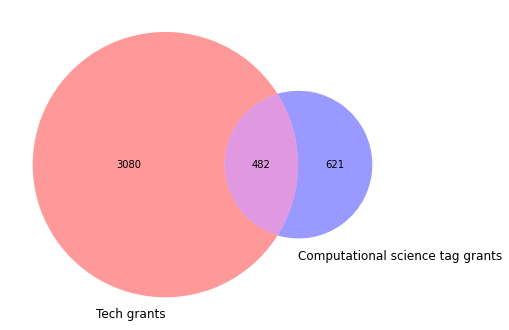

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
venn2([set(tech_grants), set(comp_grants)],
      set_labels = ('Tech grants', 'Computational science tag grants'), 
     set_colors = ['red','blue'])

## Trends in the computational science tagged grants in and out of the tech grant list

In [6]:
def get_years(grant_data, comp_grants_info):
    tech_years = grant_data['Financial start Year'].value_counts().sort_index(ascending=True).to_dict()
    comp_years = comp_grants_info['Start year'].value_counts().sort_index(ascending=True).to_dict()
    all_years = set(tech_years.keys()).union(set(comp_years.keys()))
    for year in all_years:
        if year not in tech_years:
            tech_years[year] = 0
        if year not in comp_years:
            comp_years[year] = 0
    tech_years_prop = {k:v/sum(tech_years.values()) for k,v in tech_years.items()}
    comp_years_prop = {k:v/sum(comp_years.values()) for k,v in comp_years.items()}
    return tech_years_prop, comp_years_prop

In [7]:
tech_years_prop, comp_years_prop = get_years(grant_data, comp_grants_info)

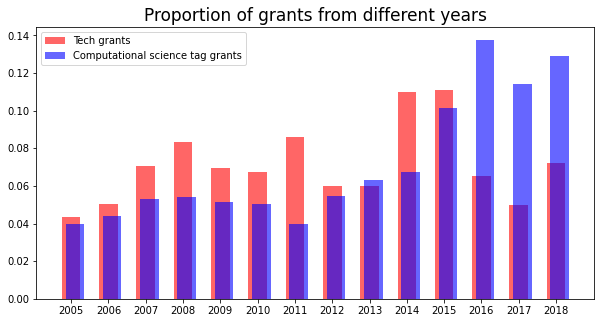

In [8]:
plt.figure(figsize = (10,5))
X = np.arange(len(tech_years_prop))
ax = plt.subplot(111)
ax.bar(X, tech_years_prop.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, comp_years_prop.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, tech_years_prop.keys())
plt.title("Proportion of grants from different years", fontsize=17)
plt.show()

In [9]:
def get_grantype(grant_data, comp_grants_info):
    tech_granttype = grant_data['Grant Programme:Title'].value_counts().to_dict()
    comp_granttype = comp_grants_info['Master Grant Type Scheme Name (Scheme)'].value_counts().to_dict()
    all_granttype = set(tech_granttype.keys()).union(set(comp_granttype.keys()))
    for granttype in all_granttype:
        if granttype not in tech_granttype:
            tech_granttype[granttype] = 0
        if granttype not in comp_granttype:
            comp_granttype[granttype] = 0
    tech_granttype_prop = {k:v/sum(tech_granttype.values()) for k,v in tech_granttype.items()}
    comp_granttype_prop = {k:v/sum(comp_granttype.values()) for k,v in comp_granttype.items()}
    return tech_granttype_prop, comp_granttype_prop

In [10]:
tech_granttype_prop, comp_granttype_prop = get_grantype(grant_data, comp_grants_info)

In [11]:
prop_threshold = 0.01
top_granttypes = set([k for k,v in tech_granttype_prop.items() if v>prop_threshold]).union(
    set([k for k,v in comp_granttype_prop.items() if v>prop_threshold]))

top_tech_granttype_prop = {k:v for k,v in tech_granttype_prop.items() if k in top_granttypes}
top_comp_granttype_prop = {k:v for k,v in comp_granttype_prop.items() if k in top_granttypes}

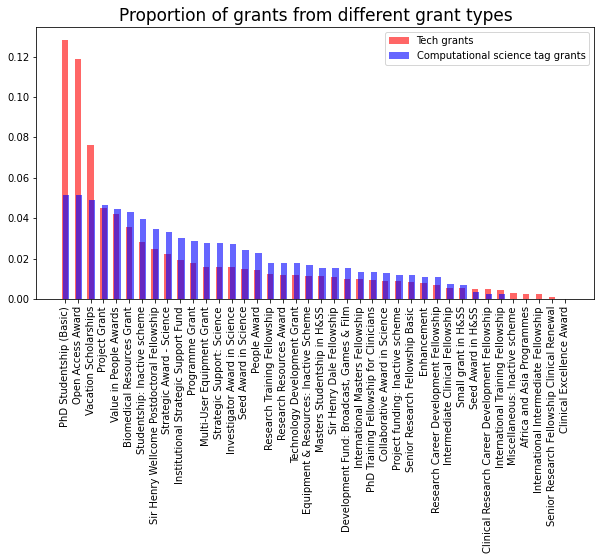

In [12]:
plt.figure(figsize = (10,5))
X = np.arange(len(top_tech_granttype_prop))
ax = plt.subplot(111)
ax.bar(X, top_tech_granttype_prop.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, top_comp_granttype_prop.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, top_tech_granttype_prop.keys(), rotation=90)
plt.title("Proportion of grants from different grant types", fontsize=17)
plt.show()

In [13]:
def get_phd_years(grant_data, comp_grants_info):
    tech_phd_years = grant_data.loc[grant_data['Grant Programme:Title'] == 'PhD Studentship (Basic)']['Financial start Year'].value_counts().sort_index(ascending=True).to_dict()
    comp_phd_years = comp_grants_info.loc[comp_grants_info['Master Grant Type Scheme Name (Scheme)'] == 'PhD Studentship (Basic)']['Start year'].value_counts().sort_index(ascending=True).to_dict()
    all_years = set(tech_phd_years.keys()).union(set(comp_phd_years.keys()))
    for year in all_years:
        if year not in tech_phd_years:
            tech_phd_years[year] = 0
        if year not in comp_phd_years:
            comp_phd_years[year] = 0
    tech_phd_years = {k:v/sum(tech_phd_years.values()) for k,v in tech_phd_years.items()}
    comp_phd_years = {k:v/sum(comp_phd_years.values()) for k,v in comp_phd_years.items()}
    return tech_phd_years, comp_phd_years

In [14]:
tech_phd_years, comp_phd_years = get_phd_years(grant_data, comp_grants_info)

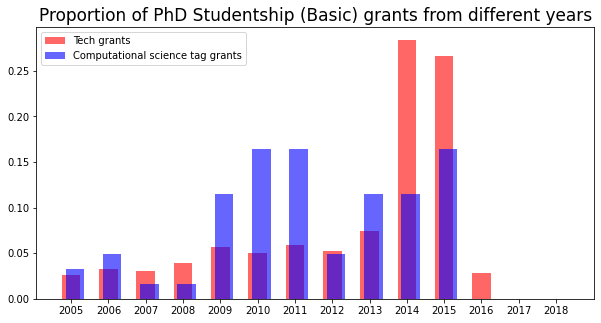

In [15]:
plt.figure(figsize = (10,5))
X = np.arange(len(tech_phd_years))
ax = plt.subplot(111)
ax.bar(X, tech_phd_years.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, comp_phd_years.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, tech_phd_years.keys())
plt.title("Proportion of PhD Studentship (Basic) grants from different years", fontsize=17)
plt.show()

## 42 data predictions

In [18]:
tech_grants = pd.read_csv('../data/processed/predictions/210403/all_grants_fortytwo_info_210420_tagged.csv')
tech_grants = tech_grants[tech_grants['Tech grant prediction']==1]['Grant ID'].tolist()
len(tech_grants)

15199

In [19]:
grant_data = pd.read_csv('../data/raw/wellcome-grants-awarded-2005-2019.csv')
grant_data = grant_data.loc[grant_data['Internal ID'].isin(tech_grants)]

grant_data['Financial start Year'] = [y[0:4] for y in grant_data['Financial Year']]

len(grant_data)

3003

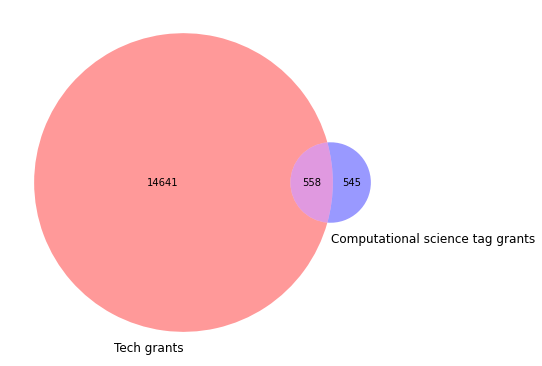

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
venn2([set(tech_grants), set(comp_grants)],
      set_labels = ('Tech grants', 'Computational science tag grants'), 
     set_colors = ['red','blue'])

## Trends in the computational science tagged grants in and out of the tech grant list

In [21]:
tech_years_prop, comp_years_prop = get_years(grant_data, comp_grants_info)

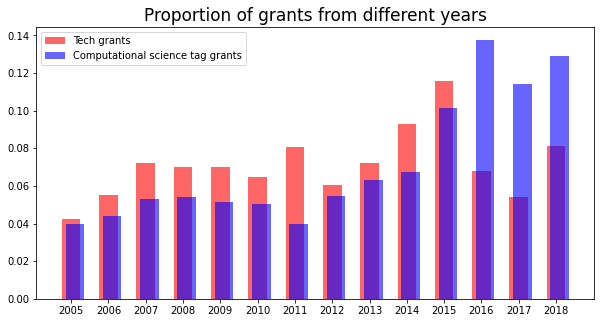

In [22]:
plt.figure(figsize = (10,5))
X = np.arange(len(tech_years_prop))
ax = plt.subplot(111)
ax.bar(X, tech_years_prop.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, comp_years_prop.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, tech_years_prop.keys())
plt.title("Proportion of grants from different years", fontsize=17)
plt.show()

In [23]:
tech_granttype_prop, comp_granttype_prop = get_grantype(grant_data, comp_grants_info)

In [24]:
prop_threshold = 0.01
top_granttypes = set([k for k,v in tech_granttype_prop.items() if v>prop_threshold]).union(
    set([k for k,v in comp_granttype_prop.items() if v>prop_threshold]))

top_tech_granttype_prop = {k:v for k,v in tech_granttype_prop.items() if k in top_granttypes}
top_comp_granttype_prop = {k:v for k,v in comp_granttype_prop.items() if k in top_granttypes}

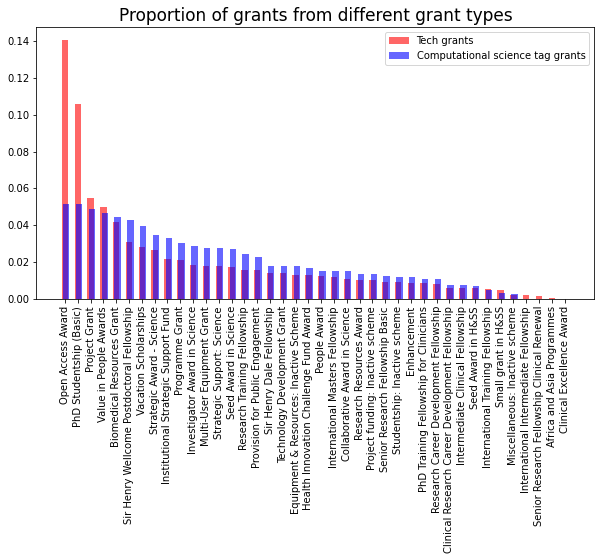

In [25]:
plt.figure(figsize = (10,5))
X = np.arange(len(top_tech_granttype_prop))
ax = plt.subplot(111)
ax.bar(X, top_tech_granttype_prop.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, top_comp_granttype_prop.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, top_tech_granttype_prop.keys(), rotation=90)
plt.title("Proportion of grants from different grant types", fontsize=17)
plt.show()

In [26]:
tech_phd_years, comp_phd_years = get_phd_years(grant_data, comp_grants_info)

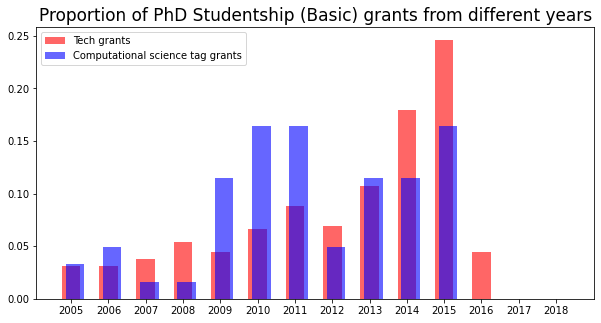

In [27]:
plt.figure(figsize = (10,5))
X = np.arange(len(tech_phd_years))
ax = plt.subplot(111)
ax.bar(X, tech_phd_years.values(), width=0.5, color='r', alpha = 0.6, align='center')
ax.bar(X+0.1, comp_phd_years.values(), width=0.5, color='b', alpha = 0.6, align='center')
ax.legend(('Tech grants', 'Computational science tag grants'))
plt.xticks(X, tech_phd_years.keys())
plt.title("Proportion of PhD Studentship (Basic) grants from different years", fontsize=17)
plt.show()